<a href="https://colab.research.google.com/github/ulalithap/My_Projects/blob/main/Fake_News_Detection_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
import re, nltk, string
from string import punctuation
from nltk.corpus import stopwords
from sklearn import metrics
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import itertools
import seaborn as sns
from collections import defaultdict
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df_fake=pd.read_csv('Fake.csv', on_bad_lines='skip')
df_fake.head()
#, on_bad_lines='skip' when error : ParserError: Error tokenizing data

In [14]:
df_fake=df_fake.drop(['subject','date'],axis=1)
df_fake['label']='FAKE'
df_fake.shape

(46148, 3)

In [15]:
df_true=pd.read_csv('True.csv')
df_true=df_true.drop(['subject','date'],axis=1)
df_true['label']='TRUE'
df_true.shape

(21417, 3)

In [16]:
df_fake.head()

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,FAKE
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,FAKE
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",FAKE
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",FAKE
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,FAKE


In [17]:
df_true.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,TRUE
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,TRUE
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,TRUE
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,TRUE
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,TRUE


In [19]:
df=pd.concat([df_true,df_fake],ignore_index=True)
df.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,TRUE
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,TRUE
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,TRUE
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,TRUE
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,TRUE


In [21]:
#shuffling dataset
df=df.reindex(np.random.permutation(df.index))
df.head()

,title,text,label
21285,Colombia protests what it says was Venezuelan ...,BOGOTA (Reuters) - Colombia has sent a letter ...,TRUE
52265,[VIDEO] HILLARY’S VAN BLOWS BY ELDERLY PEOPLE ...,Hillary s for all Everyday Americans just not...,FAKE
28631,WATCH: Hypocrite Trump Supporter Gets BURIED ...,Just like Trump campaign manager Kellyanne Con...,FAKE
53691,BLACK LIVES MATTER ORGANIZER Refuses To Meet W...,"Pure gold The ultimate Race-Baiter-In-Chief, j...",FAKE
2878,China's Xi urges joint efforts to keep China-U...,BEIJING (Reuters) - Chinese President Xi Jinpi...,TRUE


In [22]:
def extract_text(text):
    regex=re.search(r"(?<=\(Reuters\)\s\-\s).*",text)
    if regex:
      return regex.group(0)
    return text

df['text_processed']=df['text'].apply(extract_text)
df.head()

,title,text,label,text_processed
21285,Colombia protests what it says was Venezuelan ...,BOGOTA (Reuters) - Colombia has sent a letter ...,TRUE,Colombia has sent a letter of protest to Venez...
52265,[VIDEO] HILLARY’S VAN BLOWS BY ELDERLY PEOPLE ...,Hillary s for all Everyday Americans just not...,FAKE,Hillary s for all Everyday Americans just not...
28631,WATCH: Hypocrite Trump Supporter Gets BURIED ...,Just like Trump campaign manager Kellyanne Con...,FAKE,Just like Trump campaign manager Kellyanne Con...
53691,BLACK LIVES MATTER ORGANIZER Refuses To Meet W...,"Pure gold The ultimate Race-Baiter-In-Chief, j...",FAKE,"Pure gold The ultimate Race-Baiter-In-Chief, j..."
2878,China's Xi urges joint efforts to keep China-U...,BEIJING (Reuters) - Chinese President Xi Jinpi...,TRUE,Chinese President Xi Jinping urged joint effor...


In [23]:
df=df.drop(['text'],axis=1)
df['label']=df.label.apply(lambda x:1 if x=='TRUE' else 0)
df.head()

,title,label,text_processed
21285,Colombia protests what it says was Venezuelan ...,1,Colombia has sent a letter of protest to Venez...
52265,[VIDEO] HILLARY’S VAN BLOWS BY ELDERLY PEOPLE ...,0,Hillary s for all Everyday Americans just not...
28631,WATCH: Hypocrite Trump Supporter Gets BURIED ...,0,Just like Trump campaign manager Kellyanne Con...
53691,BLACK LIVES MATTER ORGANIZER Refuses To Meet W...,0,"Pure gold The ultimate Race-Baiter-In-Chief, j..."
2878,China's Xi urges joint efforts to keep China-U...,1,Chinese President Xi Jinping urged joint effor...


In [25]:
df['final_news']=df['title'] + " " + df['text_processed']
cols_del=['title','text_processed']
df=df.drop(cols_del,axis=1)
df.head()

,label,final_news
21285,1,Colombia protests what it says was Venezuelan ...
52265,0,[VIDEO] HILLARY’S VAN BLOWS BY ELDERLY PEOPLE ...
28631,0,WATCH: Hypocrite Trump Supporter Gets BURIED ...
53691,0,BLACK LIVES MATTER ORGANIZER Refuses To Meet W...
2878,1,China's Xi urges joint efforts to keep China-U...


In [26]:
#remove stop words,alpha numeric plus make lower case
stop=stopwords.words('english')
def cleanText(txt):
    txt=txt.lower()
    txt=" ".join([word for word in txt.split() if word not in (stop)])
    txt=re.sub('[^a-z]',' ',txt)
    return txt
df['final_news']=df['final_news'].apply(cleanText)
df.head()

,label,final_news
21285,1,colombia protests says venezuelan military inc...
52265,0,video hillary s van blows elderly people whe...
28631,0,watch hypocrite trump supporter gets buried w...
53691,0,black lives matter organizer refuses meet obam...
2878,1,china s xi urges joint efforts keep china u s ...


In [28]:
#GLOVE word embeddings: GLOVE works well with LSTM in text classification
# https://nlp.stanford.edu/projects/glove/
EMBEDDING_FILE='glove.6B.50d.txt'
# Config setting
MAX_SEQUENCE_LENGTH =100
MAX_VOCAB_SIZE=20000
EMBEDDING_DIM=50
VALIDATION_SPLIT=0.2
BATCH_SIZE=32
EPOCHS=10

X=df.drop(['label'],axis=1)
y=df['label'].values

In [33]:
# load pre-trained word vectors
word2vec={}
with open(EMBEDDING_FILE) as f:
  for line in f:
    values=line.split()
    word=values[0]
    vac=np.asarray(values[1:],dtype='float32')
    word2vec[word]=vac

tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(list(X['final_news']))

X=tokenizer.texts_to_sequences(list(X['final_news']))
X=pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print(X.shape)

(67565, 100)


In [34]:
word2idx=tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 115883 unique tokens.


In [35]:
# Prepare Embedding Matrix
num_words=min(MAX_VOCAB_SIZE,len(word2idx)+1)
embedding_matrix=np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector=word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i]=embedding_vector

In [36]:
# create embedding layer as an input to LSTM
embedding_layer=Embedding(num_words,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False)

In [37]:
# bi-directional LSTM
input_=Input(shape=(MAX_SEQUENCE_LENGTH,))
x=embedding_layer(input_)
x=Bidirectional(LSTM(15,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
output=Dense(1,activation='sigmoid')(x)
model=Model(input_,output)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           1000000   
                                                                 
 bidirectional (Bidirection  (None, 100, 30)           7920      
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 30)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 1007951 (3.85 MB)
Trainable params: 7951 (31.06

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=0)
r=model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=VALIDATION_SPLIT)

Epoch 1/10
1352/1352 [==============================] - 112s 80ms/step - loss: 0.1768 - accuracy: 0.9311 - val_loss: 0.1070 - val_accuracy: 0.9611
Epoch 2/10
1352/1352 [==============================] - 100s 74ms/step - loss: 0.0912 - accuracy: 0.9674 - val_loss: 0.0841 - val_accuracy: 0.9692
Epoch 3/10
1352/1352 [==============================] - 102s 75ms/step - loss: 0.0670 - accuracy: 0.9764 - val_loss: 0.0630 - val_accuracy: 0.9782
Epoch 4/10
1352/1352 [==============================] - 102s 76ms/step - loss: 0.0532 - accuracy: 0.9811 - val_loss: 0.0584 - val_accuracy: 0.9784
Epoch 5/10
1352/1352 [==============================] - 98s 73ms/step - loss: 0.0427 - accuracy: 0.9853 - val_loss: 0.0522 - val_accuracy: 0.9811
Epoch 6/10
1352/1352 [==============================] - 101s 75ms/step - loss: 0.0346 - accuracy: 0.9884 - val_loss: 0.0453 - val_accuracy: 0.9846
Epoch 7/10
1352/1352 [==============================] - 101s 74ms/step - loss: 0.0274 - accuracy: 0.9914 - val_loss: 0.

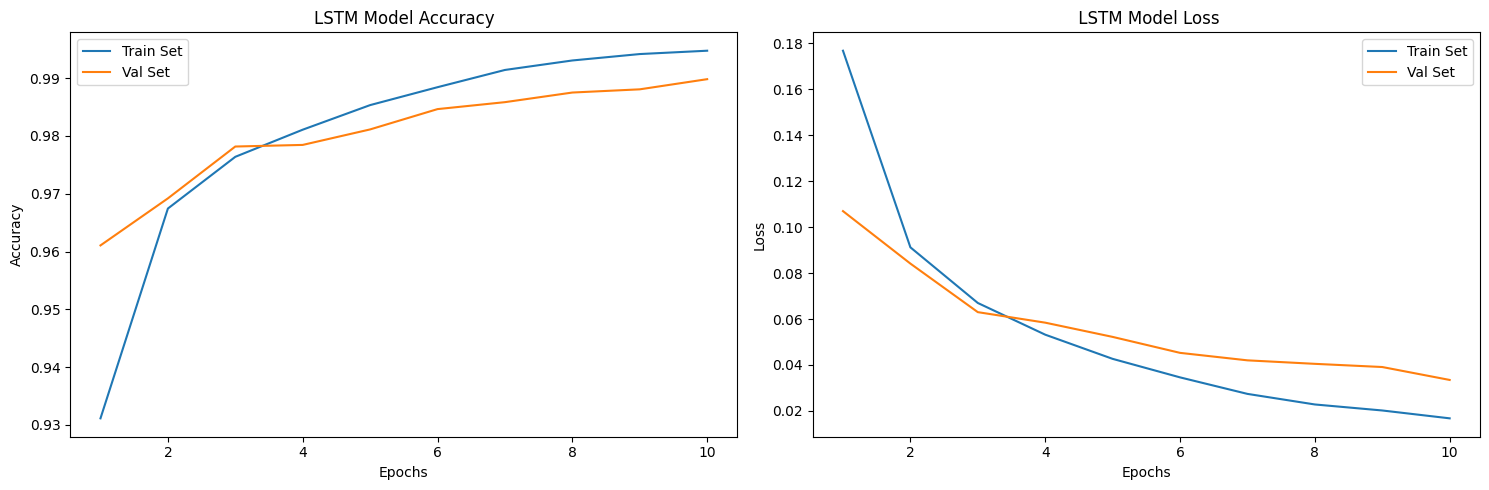

In [40]:
acc=r.history['accuracy']
val_acc=r.history['val_accuracy']
loss=r.history['loss']
val_loss=r.history['val_loss']
epochs_range=range(1,len(r.epoch)+1)
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Train Set')
plt.plot(epochs_range,val_acc,label='Val Set')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM Model Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Train Set')
plt.plot(epochs_range, val_loss,label='Val Set')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' LSTM Model Loss')

plt.tight_layout()
plt.show()


In [41]:
print('Accuracy pf model on Training Data', model.evaluate(X_train,y_train)[1]*100)
print('Accuracy of model on Test Data', model.evaluate(X_test,y_test)[1]*100)

1690/1690 [==============================] - 51s 30ms/step - loss: 0.0153 - accuracy: 0.9960
Accuracy pf model on Training Data 99.60408210754395
423/423 [==============================] - 14s 32ms/step - loss: 0.0282 - accuracy: 0.9910
Accuracy of model on Test Data 99.09716844558716


In [42]:
pred=model.predict(X_test)
pred[:10]

423/423 [==============================] - 11s 24ms/step


array([[3.4890076e-05],
       [3.1589135e-04],
       [3.2913772e-07],
       [2.4723445e-06],
       [2.3643913e-06],
       [8.9651294e-05],
       [8.6846321e-06],
       [4.9760903e-08],
       [9.9720389e-01],
       [9.4465286e-06]], dtype=float32)

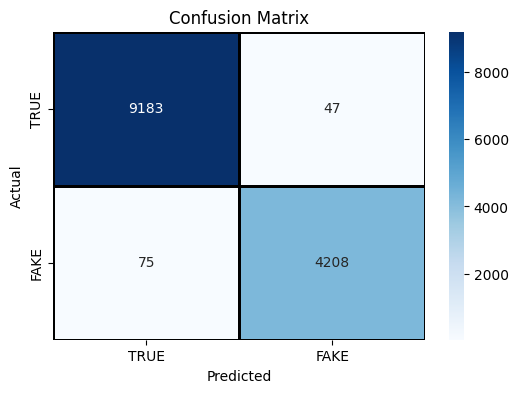

In [43]:
# Confusion Matrix
cm=confusion_matrix(y_test,pred.round())
cm=pd.DataFrame(cm,index=['TRUE','FAKE'],columns=['TRUE','FAKE'])
plt.figure(figsize=(6,4))
sns.heatmap(cm,cmap='Blues',linecolor='black',linewidth=1,annot=True,fmt='',xticklabels=['TRUE','FAKE'],yticklabels=['TRUE','FAKE'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [44]:
print(classification_report(y_test,pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9230
           1       0.99      0.98      0.99      4283

    accuracy                           0.99     13513
   macro avg       0.99      0.99      0.99     13513
weighted avg       0.99      0.99      0.99     13513



In [45]:
y_pred=model.predict(X_test).ravel()

423/423 [==============================] - 15s 36ms/step


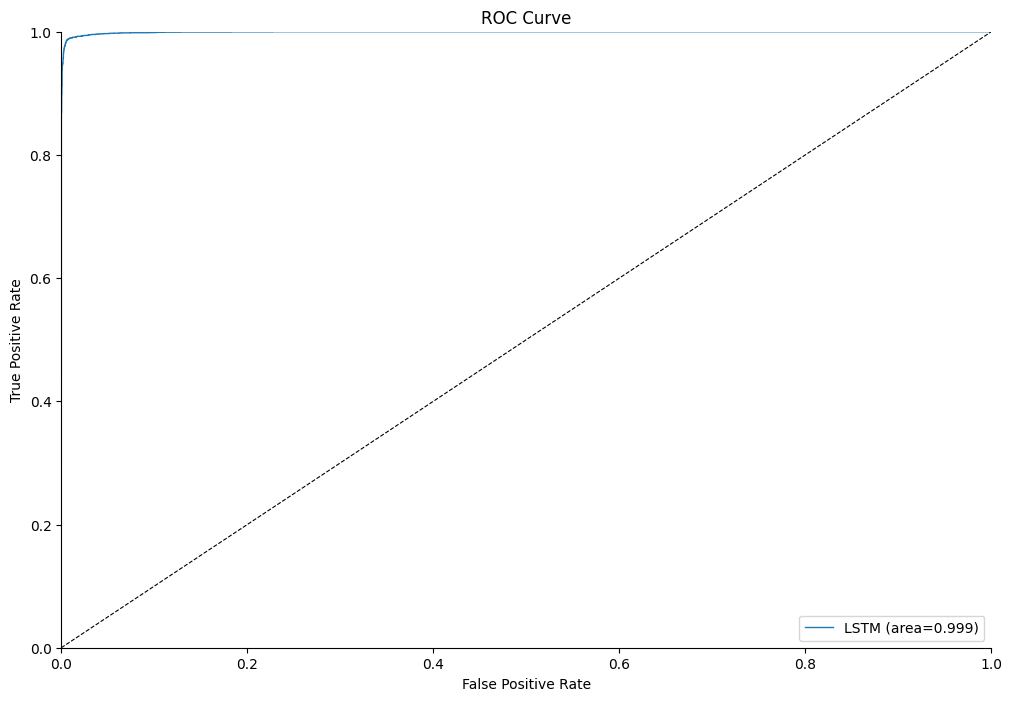

In [49]:
def roc_auc_plot(y_true,y_proba,label=' ',l='-',lw=1.0):
   fpr,tpr,_=roc_curve(y_true,y_proba)
   ax.plot(fpr,tpr,linestyle=l,linewidth=lw,label='%s (area=%.3f)'%(label,roc_auc_score(y_true,y_proba)))

f, ax=plt.subplots(figsize=(12,8))
roc_auc_plot(y_test,y_pred,label='LSTM',l='-')

ax.plot([0,1],[0,1],color='k',linewidth=0.8,linestyle='--',)
ax.legend(loc='lower right')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_title('ROC Curve')
sns.despine()



In [51]:
testSent=["Trey Gowdy destroys this clueless DHS employee when asking about the due process of getting on the terror watch list. Her response is priceless:  I m sorry, um, there s not a process afforded the citizen prior to getting on the list.  ",
       "Poland s new prime minister faces a difficult balancing act trying to repair bruised relations with the European Union without alienating the eurosceptic government s core voters. A Western-educated former banker who is fluent in German and English and was sworn in on Monday, Mateusz Morawiecki boasts the credentials needed to negotiate with Brussels. But any compromises to improve relations with Brussels, which sees the ruling Law and Justice (PiS) party as a threat to democracy, would risk upsetting the traditional, Catholic supporters who propelled it into power two years ago. It is a gamble that could backfire, and it is not yet clear how far Morawiecki, 49, and his party, dominated by former Prime Minister Jaroslaw Kaczynski, are ready to go to please Brussels.   The idea to build up international credibility seems rational,  said Jaroslaw Flis, a sociologist at the Jagiellonian University.  But such actions would have to be in complete contrast with what Mateusz Morawiecki would have to do domestically to prevent the PiS from falling apart."]

In [52]:
def predict_text(lst_text):
    test=tokenizer.texts_to_sequences(lst_text)
    testX=pad_sequences(test,maxlen=MAX_SEQUENCE_LENGTH)
    df_test=pd.DataFrame(lst_text, columns=['test_sent'])
    prediction=model.predict(testX)
    df_test['prediction']=prediction
    df_test['test_sent']=df_test['test_sent'].apply(cleanText)
    df_test['prediction']=df_test['prediction'].apply(lambda x: 'Fake' if x>=0.5 else 'Real')
    return df_test

In [54]:
df_testSent=predict_text(testSent)
df_testSent

1/1 [==============================] - 0s 30ms/step


,test_sent,prediction
0,trey gowdy destroys clueless dhs employee aski...,Real
1,poland new prime minister faces difficult bala...,Fake
